In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"MediaPipe version: {mp.__version__}")

TensorFlow version: 2.13.0
OpenCV version: 4.10.0
MediaPipe version: 0.10.14


In [21]:
# Step 2: Load and preprocess the data
def load_data(data_dir):
    X = []
    y = []
    for label in tqdm(os.listdir(data_dir), desc="Loading data"):
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [23]:
data_dir = "./dataset/asl_alphabet_train/asl_alphabet_train/"
X, y = load_data(data_dir)

Loading data:  15%|██████████▎                                                          | 6/40 [06:46<38:21, 67.69s/it]

KeyboardInterrupt



In [ ]:
print(y)

In [45]:
# Step 3: Set up MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

In [47]:
# Step 4: Extract hand landmarks
def extract_landmarks(image):
    results = hands.process(image)
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0].landmark
        return np.array([[l.x, l.y, l.z] for l in landmarks])
    return None

In [51]:
X_landmarks = []
for img in X:
    landmarks = extract_landmarks(img)
    if landmarks is not None:
        X_landmarks.append(landmarks)
    else:
        X_landmarks.append(np.zeros((21, 3)))  # Placeholder for images without detected hands

X_landmarks = np.array(X_landmarks)

C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [82]:
# Step 5: Prepare the data for training
label_map = {label: i for i, label in enumerate(np.unique(y))}
y_encoded = np.array([label_map[label] for label in y])
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_landmarks, y_categorical, test_size=0.2, random_state=42)

# Print the shape of the training data
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (69600, 21, 3)
y_train shape: (69600, 29)


In [84]:
# Step 6: Define the model architecture
num_classes = len(label_map)

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(21, 3)),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [86]:
# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 19, 64)            640       
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 9, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 256)            98560     
                                                                 
 global_average_pooling1d_1  (None, 256)              

In [88]:
# Step 7: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
# Step 8: Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
1740/1740 [==============================] - 21s 10ms/step - loss: 1.7686 - accuracy: 0.4693 - val_loss: 1.0589 - val_accuracy: 0.7145
Epoch 2/50
1740/1740 [==============================] - 17s 10ms/step - loss: 1.1159 - accuracy: 0.6886 - val_loss: 0.9999 - val_accuracy: 0.7208
Epoch 3/50
1740/1740 [==============================] - 17s 10ms/step - loss: 1.0392 - accuracy: 0.7143 - val_loss: 0.9773 - val_accuracy: 0.7306
Epoch 4/50
1740/1740 [==============================] - 17s 10ms/step - loss: 1.0002 - accuracy: 0.7250 - val_loss: 0.9392 - val_accuracy: 0.7447
Epoch 5/50
1740/1740 [==============================] - 17s 10ms/step - loss: 0.9753 - accuracy: 0.7326 - val_loss: 0.9173 - val_accuracy: 0.7548
Epoch 6/50
1740/1740 [==============================] - 17s 10ms/step - loss: 0.9578 - accuracy: 0.7381 - val_loss: 0.9193 - val_accuracy: 0.7514
Epoch 7/50
1740/1740 [==============================] - 17s 10ms/step - loss: 0.9426 - accuracy: 0.7426 - val_loss: 0.9065 -

In [95]:
# Step 9: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

544/544 [==============================] - 3s 4ms/step - loss: 0.8889 - accuracy: 0.7581
Test accuracy: 0.7581


In [97]:
# Step 10: Save the model for edge deployment
model.save('asl_recognition_model21.h5')

C:\Users\abhis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


544/544 [==============================] - 1s 3ms/step


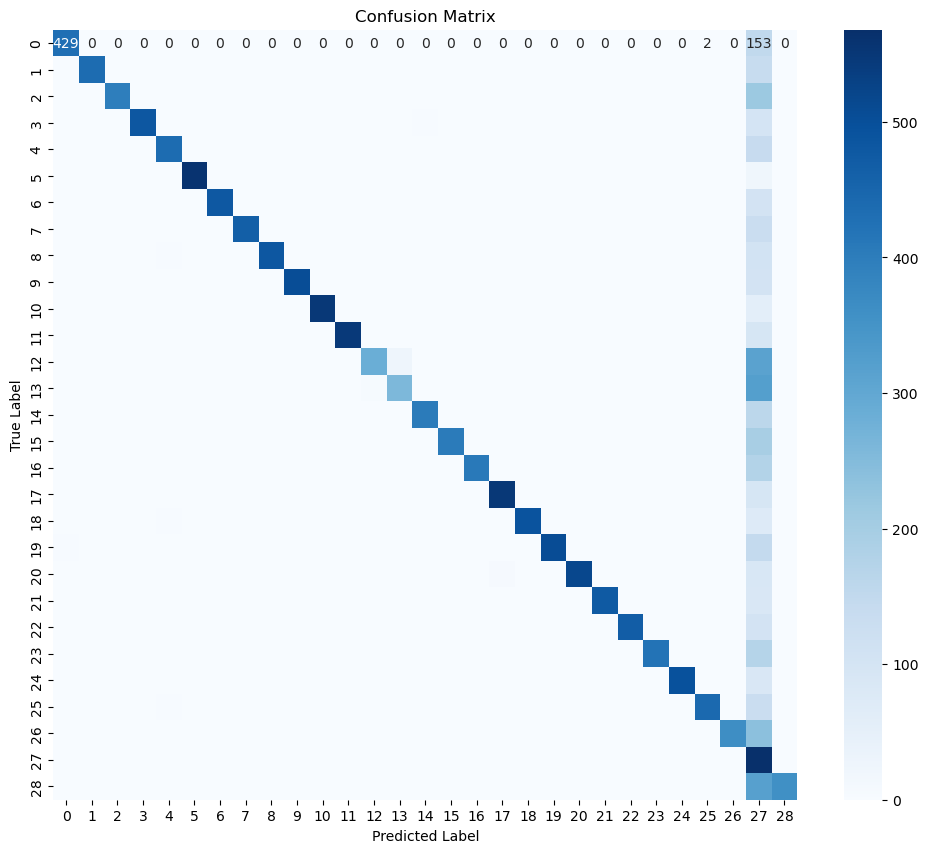

In [105]:
# Step 10: Generate and visualize confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [107]:
# Calculate TP, FP, TN, FN
num_classes = cm.shape[0]
tp = np.diag(cm)
fp = np.sum(cm, axis=0) - tp
fn = np.sum(cm, axis=1) - tp
tn = np.sum(cm) - (fp + fn + tp)

print("\nConfusion Matrix Metrics:")
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  True Positive: {tp[i]}")
    print(f"  False Positive: {fp[i]}")
    print(f"  True Negative: {tn[i]}")
    print(f"  False Negative: {fn[i]}")
    print()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=list(label_map.keys())))


Confusion Matrix Metrics:
Class 0:
  True Positive: 429
  False Positive: 6
  True Negative: 16810
  False Negative: 155

Class 1:
  True Positive: 436
  False Positive: 2
  True Negative: 16824
  False Negative: 138

Class 2:
  True Positive: 399
  False Positive: 2
  True Negative: 16781
  False Negative: 218

Class 3:
  True Positive: 483
  False Positive: 2
  True Negative: 16809
  False Negative: 106

Class 4:
  True Positive: 437
  False Positive: 10
  True Negative: 16810
  False Negative: 143

Class 5:
  True Positive: 560
  False Positive: 1
  True Negative: 16814
  False Negative: 25

Class 6:
  True Positive: 480
  False Positive: 1
  True Negative: 16812
  False Negative: 107

Class 7:
  True Positive: 465
  False Positive: 2
  True Negative: 16799
  False Negative: 134

Class 8:
  True Positive: 482
  False Positive: 2
  True Negative: 16800
  False Negative: 116

Class 9:
  True Positive: 504
  False Positive: 1
  True Negative: 16789
  False Negative: 106

Class 10:
  T

In [111]:
# Step 11: Test on new images
def process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    landmarks = extract_landmarks(img)
    if landmarks is not None:
        return landmarks.reshape(1, 21, 3)
    else:
        return None

def predict_asl(image_path):
    processed_image = process_image(image_path)
    if processed_image is not None:
        prediction = model.predict(processed_image)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        return list(label_map.keys())[predicted_class], confidence
    else:
        return "No hand detected", 0

# Test on images in the asl_test folder
test_folder = "./dataset/asl_alphabet_test/asl_alphabet_test/"
for image_name in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_name)
    predicted_class, confidence = predict_asl(image_path)
    print(f"Image: {image_name}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")
    print()

Image: A_test.jpg
Predicted class: No hand detected
Confidence: 0.00

1/1 [==============================] - 0s 28ms/step
Image: B_test.jpg
Predicted class: B
Confidence: 1.00

Image: C_test.jpg
Predicted class: No hand detected
Confidence: 0.00



C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Image: D_test.jpg
Predicted class: No hand detected
Confidence: 0.00

Image: E_test.jpg
Predicted class: No hand detected
Confidence: 0.00

1/1 [==============================] - 0s 23ms/step
Image: F_test.jpg
Predicted class: F
Confidence: 1.00

1/1 [==============================] - 0s 26ms/step
Image: G_test.jpg
Predicted class: G
Confidence: 1.00

Image: H_test.jpg
Predicted class: No hand detected
Confidence: 0.00

1/1 [==============================] - 0s 29ms/step
Image: I_test.jpg
Predicted class: I
Confidence: 1.00

1/1 [==============================] - 0s 25ms/step
Image: J_test.jpg
Predicted class: J
Confidence: 1.00

1/1 [==============================] - 0s 30ms/step
Image: K_test.jpg
Predicted class: K
Confidence: 1.00

1/1 [==============================] - 0s 25ms/step
Image: L_test.jpg
Predicted class: L
Confidence: 1.00

Image: M_test.jpg
Predicted class: No hand detected
Confidence: 0.00

Image: nothing_test.jpg
Predicted class: No hand detected
Confidence: 0.00

Im

In [44]:
# Step 12: Real-time ASL Recognition with Webcam

import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
import time

def initialize_label_map():
    """Initialize the label map for ASL letters"""
    return {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9,
    'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18,
    'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25
}
def real_time_asl_recognition():
    # Load the saved model
    model = load_model('asl_recognition_model21.h5')
    
    # Initialize label map
    label_map = initialize_label_map()
    # Create reverse label map for predictions
    reverse_label_map = {v: k for k, v in label_map.items()}
    
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Set frame dimensions
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    # Initialize FPS calculation
    prev_time = 0
    
    print("Starting real-time ASL recognition. Press 'q' to quit.")
    print("Available signs:", ", ".join(label_map.keys()))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
            
        # Calculate FPS
        current_time = time.time()
        fps = 1 / (current_time - prev_time)
        prev_time = current_time
        
        # Convert the BGR image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the image and detect hands
        results = hands.process(image)
        
        # Convert back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # If hands are detected, predict the ASL sign
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw hand landmarks
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=1),
                    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
                
                # Extract landmarks
                landmarks = np.array([[l.x, l.y, l.z] for l in hand_landmarks.landmark])
                landmarks = landmarks.reshape(1, 21, 3)
                
                # Make prediction
                prediction = model.predict(landmarks, verbose=0)
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                
                # Get the predicted letter using reverse label map
                predicted_letter = reverse_label_map[predicted_class]
                
                # Add prediction text to frame
                text = f"Prediction: {predicted_letter}"
                conf_text = f"Confidence: {confidence:.2f}"
                
                # Add text background
                cv2.rectangle(image, (10, 10), (300, 70), (0, 0, 0), -1)
                
                # Add text
                cv2.putText(image, text, (20, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                cv2.putText(image, conf_text, (20, 60),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Display FPS
        cv2.putText(image, f"FPS: {int(fps)}", (550, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        # Display the frame
        cv2.imshow('ASL Recognition', image)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    hands.close()

In [46]:
# Run the real-time recognition
try:
    print("Initializing real-time ASL recognition...")
    real_time_asl_recognition()
except Exception as e:
    print(f"An error occurred: {str(e)}")
    # Ensure webcam is released even if an error occurs
    cv2.VideoCapture(0).release()
    cv2.destroyAllWindows()

Initializing real-time ASL recognition...
Starting real-time ASL recognition. Press 'q' to quit.
Available signs: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z
An error occurred: 26


In [ ]:
# Optional: Convert to TensorFlow Lite for edge deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('asl_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved for edge deployment.")